In [3]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,DirectoryIterator
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import backend as K
import os
import tensorflow as tf

In [2]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   horizontal_flip=True,
                                   zoom_range=0.2,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1
                                   )
test_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory("VietNam_Medicinal_Plant/train",target_size=(150, 150),
                                                   batch_size= 128,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   )

test_generator = test_datagen.flow_from_directory("VietNam_Medicinal_Plant/test", target_size = (150,150), batch_size = 128,)

Found 12000 images belonging to 200 classes.
Found 8000 images belonging to 200 classes.


In [3]:
x_train, y_train = next(train_generator)
x_test, y_test  = next(test_generator)

### Fine-tuning InceptionV3

In [4]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(include_top=False,
                      weights='imagenet',
                      input_shape=(150, 150, 3))

x = base_model.layers[-1].output
x = Dropout(0.3)(x)
x = Conv2D(200, 3, strides = (1,1), activation='softmax')(x)
predictions = Flatten()(x)

inceptionv3_model = Model(inputs=base_model.input, outputs=predictions)

87910968/87910968 [==============================] - 26s 0us/step


In [5]:
from tensorflow.keras.optimizers import RMSprop
for layeR in base_model.layers:
    layeR.trainable = False

for layer in base_model.layers[-8:]:
    layer.trainable = True

In [6]:
inceptionv3_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [7]:
inceptionv3_model.compile(optimizer = RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [8]:
history = inceptionv3_model.fit(
            train_generator,
            validation_data = test_generator,
            epochs = 20,
)

Epoch 1/20
94/94 [==============================] - 159s 2s/step - loss: 6.0539 - accuracy: 0.1838 - val_loss: 3.5748 - val_accuracy: 0.3086
Epoch 2/20
94/94 [==============================] - 180s 2s/step - loss: 3.5790 - accuracy: 0.3948 - val_loss: 3.0318 - val_accuracy: 0.4015
Epoch 3/20
94/94 [==============================] - 209s 2s/step - loss: 3.0063 - accuracy: 0.4843 - val_loss: 2.8171 - val_accuracy: 0.4475
Epoch 4/20
94/94 [==============================] - 215s 2s/step - loss: 2.7582 - accuracy: 0.5272 - val_loss: 2.7585 - val_accuracy: 0.4737
Epoch 5/20
94/94 [==============================] - 222s 2s/step - loss: 2.5313 - accuracy: 0.5617 - val_loss: 2.6182 - val_accuracy: 0.4879
Epoch 6/20
94/94 [==============================] - 202s 2s/step - loss: 2.3811 - accuracy: 0.5888 - val_loss: 2.6083 - val_accuracy: 0.4972
Epoch 7/20
94/94 [==============================] - 202s 2s/step - loss: 2.2735 - accuracy: 0.6029 - val_loss: 2.6743 - val_accuracy: 0.5010
Epoch 8/20
94

In [9]:
inceptionv3_model.save('inceptionv3')

INFO:tensorflow:Assets written to: inceptionv3/assets


INFO:tensorflow:Assets written to: inceptionv3/assets


### Plots

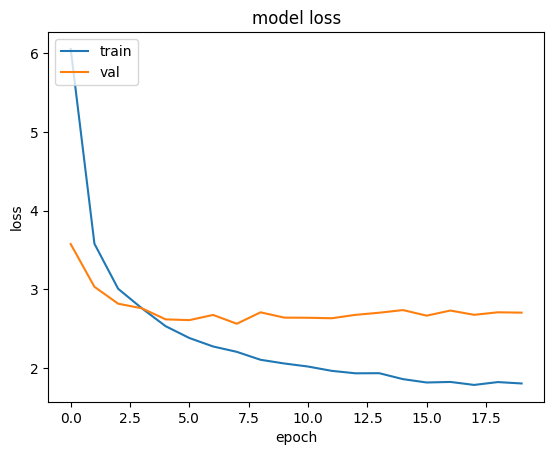

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('plots/inceptionv3_model_loss.png')

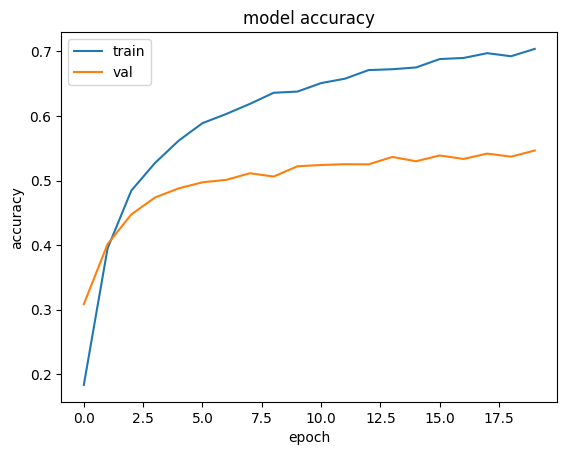

<Figure size 640x480 with 0 Axes>

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('plots/inceptionv3_model_acc.png')

In [1]:
def LoadImage(url):
    # Load image from the specified URL
    image = skimage.io.imread(url)
    return image

def transform_img(url):
    img = skimage.io.imread(url)
    img = skimage.transform.resize(img, (150,150))
    # normalizes the pixel values of the image to be in the range [-1, 1] 
    img = (img - 0.5)*2
    # adds an extra dimension to the image array to make it compatible with the input shape expected
    img = np.expand_dims(img, axis=0)
    preds = inceptionv3_model.predict(img)
    return img

In [4]:
import skimage

image_url = 'VietNam_Medicinal_Plant/test/Aloe_vera/8.JPG'
inceptionv3_image = transform_img(image_url)

NameError: name 'inceptionv3_model' is not defined

### Integrating explainability

In [34]:
import lime
from tensorflow.keras.applications import inception_v3 as inc_net
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

In [35]:
explanation = explainer.explain_instance(inceptionv3_image[0].astype('double'), inceptionv3_model.predict,  top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 93ms/step


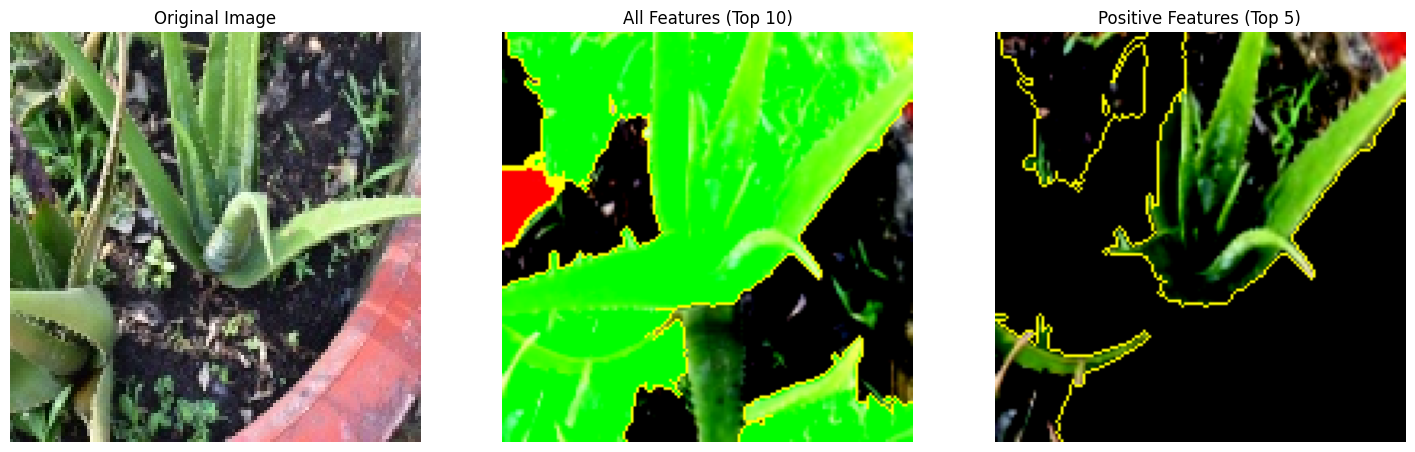

In [37]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(im_orig)
ax1.set_title('Original Image')
ax1.axis('off')

ax3.imshow(mark_boundaries(temp_1, mask_1))
ax3.set_title('Positive Features (Top 5)')
ax3.axis('off')

ax2.imshow(mark_boundaries(temp_2, mask_2))
ax2.set_title('All Features (Top 10)')
ax2.axis('off')

# plt.show()
plt.savefig('plots/inceptionv3_model_acc.png')